## Food 101 Image Classification Challenge Problem

This notebook demonstrates the training of the Food-101 dataset. It uses pytorch based implementation of fastai. The model used is ResNet50 and all the images have been resized to 256. It uses Label smoothing CE as the loss function, augmentations, Test Time Augmentations and mixup. Major reason I have resized the data to 256 and not 512 is due to the resources.

## Summary

- Model: ResNet50
- #Epochs: 15
- Augmentations: Random Transform and TTA
- top_1_accuracy: 88.15 (with TTA)
- top_5_accuracy: 97.8 (with TTA)

## Development Environment

- The training environment has been setup on Azure cloud VM
- Frameworks Used: Fastai/PyTorch

## Dataset

- This dataset consists of 101 foof categories with 1,01,000 images (1000 per class). 
- There are 750 training images and 250 reviewed images for test data. So it is a balanced dataset.
- The training data was intentionally not cleaned and so contains lot of noise.
- The images are of different qualities due to the variation in lighting conditions, cameras used, etc

In [1]:
# import fastai2
# from fastai2 import *
# from fastai2.vision.all import *
# from fastai2.distributed import *
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from shutil import copyfile
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
%matplotlib inline
import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

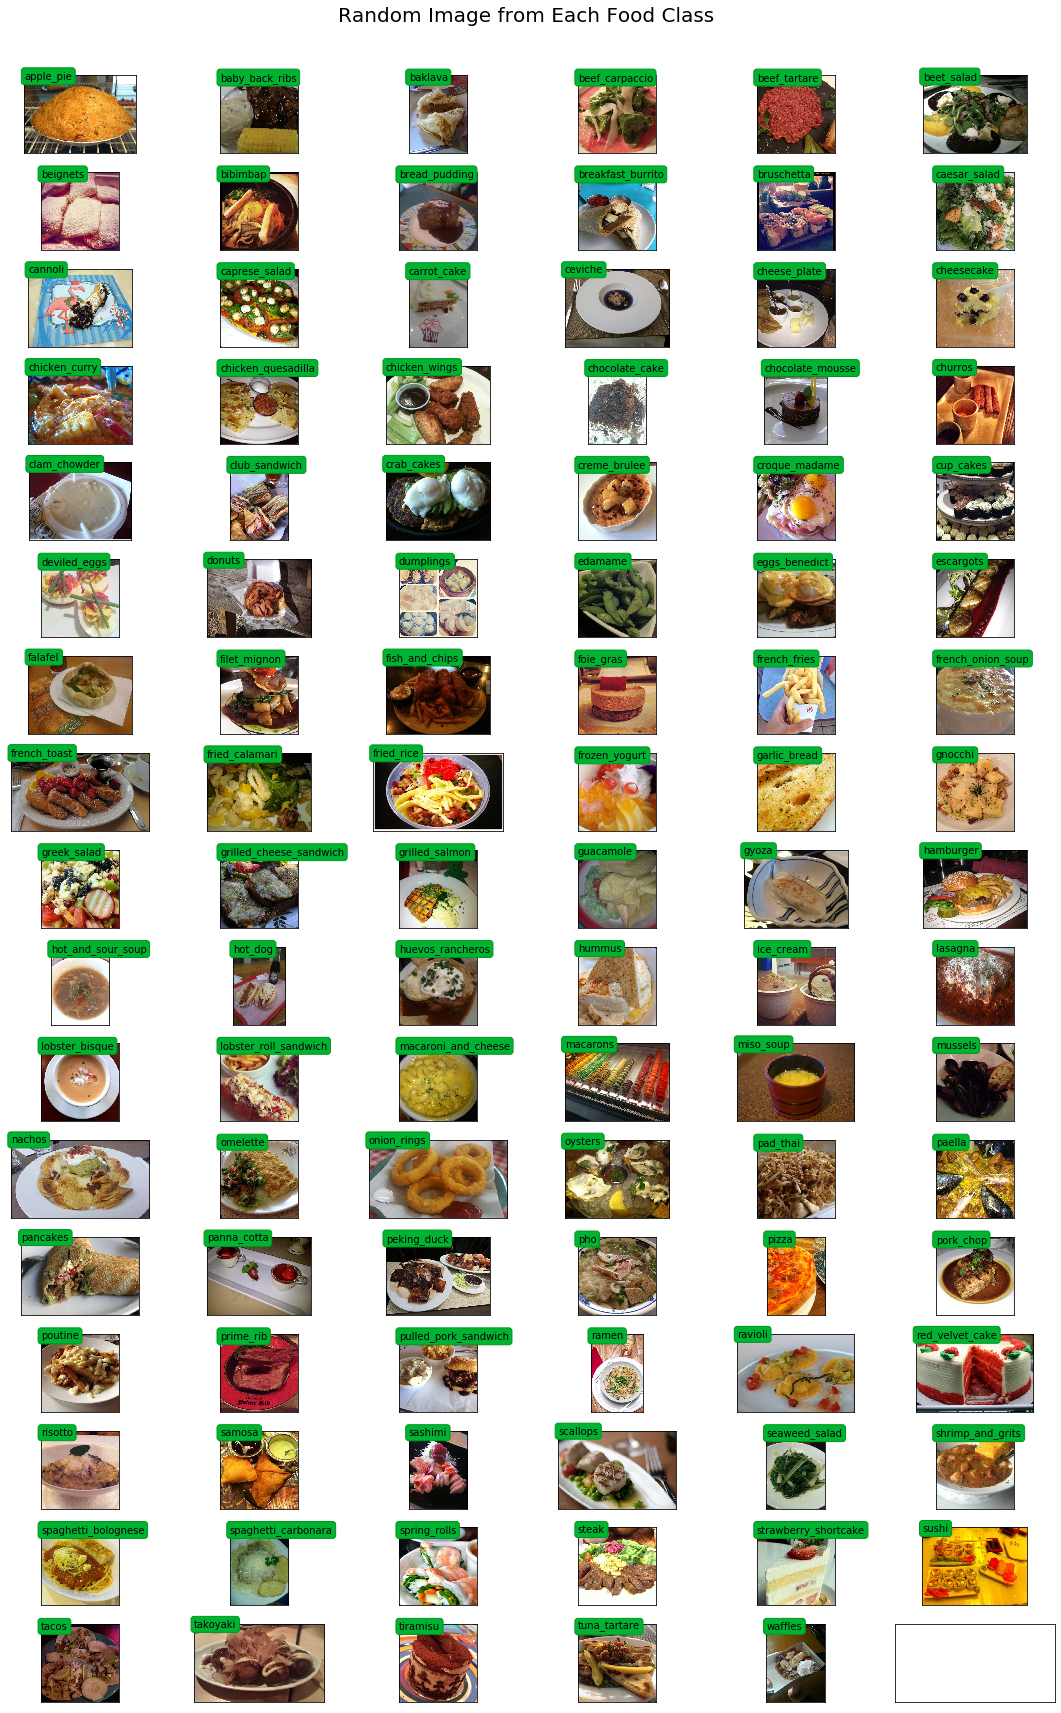

In [2]:
root_dir = "food-101/images/"
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
# if not os.path.isdir('../food-101/test') and not os.path.isdir('../food-101/train'):

#     def copytree(src, dst, symlinks = False, ignore = None):
#         if not os.path.exists(dst):
#             os.makedirs(dst)
#             shutil.copystat(src, dst)
#         lst = os.listdir(src)
#         if ignore:
#             excl = ignore(src, lst)
#             lst = [x for x in lst if x not in excl]
#         for item in lst:
#             s = os.path.join(src, item)
#             d = os.path.join(dst, item)
#             if symlinks and os.path.islink(s):
#                 if os.path.lexists(d):
#                     os.remove(d)
#                 os.symlink(os.readlink(s), d)
#                 try:
#                     st = os.lstat(s)
#                     mode = stat.S_IMODE(st.st_mode)
#                     os.lchmod(d, mode)
#                 except:
#                     pass # lchmod not available
#             elif os.path.isdir(s):
#                 copytree(s, d, symlinks, ignore)
#             else:
#                 shutil.copy2(s, d)

#     def generate_dir_file_map(path):
#         dir_files = defaultdict(list)
#         with open(path, 'r') as txt:
#             files = [l.strip() for l in txt.readlines()]
#             for f in files:
#                 dir_name, id = f.split('/')
#                 dir_files[dir_name].append(id + '.jpg')
#         return dir_files

#     train_dir_files = generate_dir_file_map('../food-101/meta/train.txt')
#     test_dir_files = generate_dir_file_map('../food-101/meta/test.txt')


#     def ignore_train(d, filenames):
#         print(d)
#         subdir = d.split('/')[-1]
#         to_ignore = train_dir_files[subdir]
#         return to_ignore

#     def ignore_test(d, filenames):
#         print(d)
#         subdir = d.split('/')[-1]
#         to_ignore = test_dir_files[subdir]
#         return to_ignore

#     copytree('../food-101/images', '../food-101/test', ignore=ignore_train)
#     copytree('../food-101/images', '../food-101/train', ignore=ignore_test)
    
# else:
#     print('Train/Test files already copied into separate folders.')

Using the train.txt, test.txt files, I have created dataframes to import images directly during the training phase. Initially my approach was to load all the images as nparrays and then do the training. Since the dataset is large, memory was not sufficient. It could only be loaded in batches. So I decided to go with the following approach.

In [4]:
import json
test_json = open('food-101/meta/test.json', 'r')
test_json = json.load(test_json)
classes = list(test_json.keys())
classes

['churros',
 'hot_and_sour_soup',
 'samosa',
 'sashimi',
 'pork_chop',
 'spring_rolls',
 'panna_cotta',
 'beef_tartare',
 'greek_salad',
 'foie_gras',
 'tacos',
 'pad_thai',
 'poutine',
 'ramen',
 'pulled_pork_sandwich',
 'bibimbap',
 'beignets',
 'apple_pie',
 'crab_cakes',
 'risotto',
 'paella',
 'steak',
 'baby_back_ribs',
 'miso_soup',
 'frozen_yogurt',
 'club_sandwich',
 'carrot_cake',
 'falafel',
 'bread_pudding',
 'chicken_wings',
 'gnocchi',
 'caprese_salad',
 'creme_brulee',
 'escargots',
 'chocolate_cake',
 'tiramisu',
 'spaghetti_bolognese',
 'mussels',
 'scallops',
 'baklava',
 'edamame',
 'macaroni_and_cheese',
 'pancakes',
 'garlic_bread',
 'beet_salad',
 'onion_rings',
 'red_velvet_cake',
 'grilled_salmon',
 'chicken_curry',
 'deviled_eggs',
 'caesar_salad',
 'hummus',
 'fish_and_chips',
 'lasagna',
 'peking_duck',
 'guacamole',
 'strawberry_shortcake',
 'clam_chowder',
 'croque_madame',
 'french_onion_soup',
 'beef_carpaccio',
 'fried_rice',
 'donuts',
 'gyoza',
 'ravio

In [14]:
train_df =  pd.read_csv('food-101/meta/train.txt',delimiter='/', header=None, names=['label', 'image_file'] )
train_df['image_file'] = train_df['label'].astype(str) + '/' + train_df['image_file'].astype(str) + '.jpg'
train_df.head()

label             image_file
0  apple_pie  apple_pie/1005649.jpg
1  apple_pie  apple_pie/1014775.jpg
2  apple_pie  apple_pie/1026328.jpg
3  apple_pie  apple_pie/1028787.jpg
4  apple_pie  apple_pie/1043283.jpg

In [6]:
test_df =  pd.read_csv('food-101/meta/test.txt',delimiter='/', header=None, names=['label', 'image_file'] )
test_df['image_file'] = test_df['label'].astype(str) + '/' + test_df['image_file'].astype(str) + '.jpg'
test_df.head()

label             image_file
0  apple_pie  apple_pie/1011328.jpg
1  apple_pie   apple_pie/101251.jpg
2  apple_pie  apple_pie/1034399.jpg
3  apple_pie   apple_pie/103801.jpg
4  apple_pie  apple_pie/1038694.jpg

## Augmentations:

- Data Augmentation is a techinique that enables deep learning algorithm to significantly increase the diversity in data avalable for training.
- Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. 
- Here, I have applied random transforms which apply flip, warp, rotate,zoom,lighting and contrast randomly
- Random transform increases the variety of data and thus prevents overfitting
- I have applied same transformations for both training sand testing (while using TTA)

### [Mixup](https://docs.fast.ai/callbacks.mixup.html#What-is-mixup?):
- A data augmentation technique which efficiently regularizes the models
- It creates new images as the combination of 2 images (not necessarily from the  same class) It applies the same factors to create the target

$$ new image = t * image1 + (1-t) * image2 $$
$$ new target = t * target1 + (1-t) * target2 $$

where t is a float between 0 and 1.


In [2]:
Crop_pads = RandTransform(tfm=TfmCrop(crop_pad),\
                       kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, \
                       p=1.0, \
                       resolved={}, \
                       do_run=True, \
                       is_random=True)

Affine_flip = RandTransform(tfm=TfmAffine(flip_affine),\
                            kwargs={}, \
                            p=0.5, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Coord_warp = RandTransform(tfm=TfmCoord(symmetric_warp), \
                           kwargs={'magnitude': (-0.2, 0.2)}, \
                           p=0.75, \
                           resolved={}, \
                           do_run=True, \
                           is_random=True)

Affine_rotate = RandTransform(tfm=TfmAffine(rotate),\
                              kwargs={'degrees': (-20.0, 20.0)}, \
                              p=0.75, \
                              resolved={}, \
                              do_run=True, \
                              is_random=True)

Affine_zoom = RandTransform(tfm=TfmAffine(zoom), \
                            kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, \
                            p=0.75, \
                            resolved={}, \
                            do_run=True, \
                            is_random=True)

Lighting_brightness = RandTransform(tfm=TfmLighting(brightness), \
                         kwargs={'change': (0.4, 0.6)}, \
                         p=0.75, \
                         resolved={}, \
                         do_run=True, \
                         is_random=True)

Lighting_contrast = RandTransform(tfm=TfmLighting(contrast),\
                                  kwargs={'scale': (0.8, 1.25)}, \
                                  p=0.75, \
                                  resolved={}, \
                                  do_run=True,\
                                  is_random=True)

Crops = RandTransform(tfm=TfmCrop(crop_pad), \
                      kwargs={}, \
                      p=1.0, \
                      resolved={},\
                      do_run=True, \
                      is_random=True)

# Training Set Random Augmentation
train_tfms = [Crop_pads,Affine_flip,Coord_warp,Affine_rotate,Affine_zoom,Lighting_brightness,Lighting_contrast]

# validation set Random Augmentation
valid_tfms = [Crops]

random_tfms = (train_tfms,valid_tfms)

In [33]:
i = np.random.choice(train_df.index.values, 1)
train_df.iloc[i]['image_file'].values[0]

'spaghetti_bolognese/664689.jpg'

The above train augmentations are applied on a single image for visualization

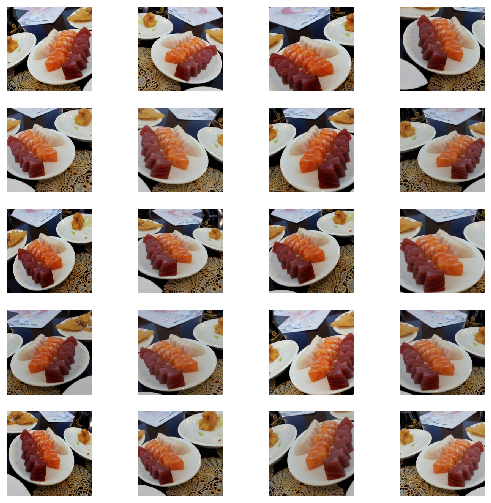

In [37]:
_, axs = plt.subplots(5,4,figsize=(9,9))
i = np.random.choice(train_df.index.values, 1)
    
img_name = 'food-101/images/' + train_df.iloc[i]['image_file'].values[0]
for ax in axs.flatten(): 
    img = open_image(img_name)
    img = img.apply_tfms(train_tfms, img, size=224)
    img.show(ax=ax)

In [8]:
train_model_data = (ImageList.from_df(df=train_df,path = ".",folder="food-101/images", cols=1)\
                            .split_by_rand_pct(0.2)\
                            .label_from_df(cols=0)\
                            .transform(random_tfms, size=256)\
                            .databunch(bs=64)\
                            .normalize(imagenet_stats))

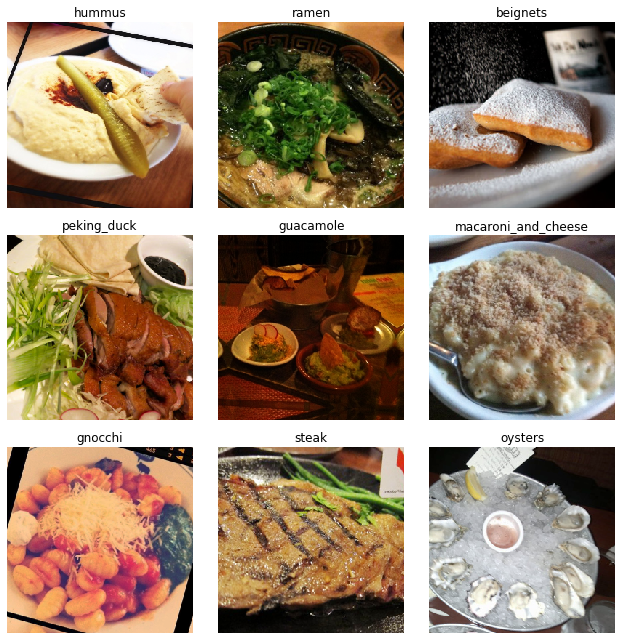

In [9]:
train_model_data.show_batch(rows=3, figsize=(9, 9))

## Training

For training, the parameters used are:
- Metrics: accuracy and top_5_accuracy
- Loss function: LabelSmoothingCrossEntropy
- Batch Size: 64
- Image Size: 256*256

In [10]:
top_5_accuracy = partial(top_k_accuracy, k=5)

learn = cnn_learner(train_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph,
                   loss_func=LabelSmoothingCrossEntropy()).mixup()

In [11]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [12]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 fastai.train.ShowGraph,
 functools.partial(<class 'fastai.callbacks.mixup.MixUpCallback'>, alpha=0.4, stack_x=False, stack_y=True)]

In [13]:
learn = learn.to_fp16(dynamic=True);
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


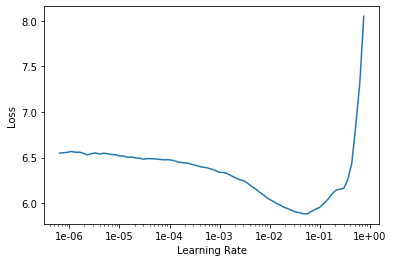

In [14]:
learn.lr_find()
learn.recorder.plot()

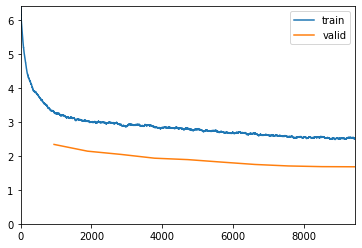

In [15]:
learn.fit_one_cycle(10, max_lr=slice(1e-2))

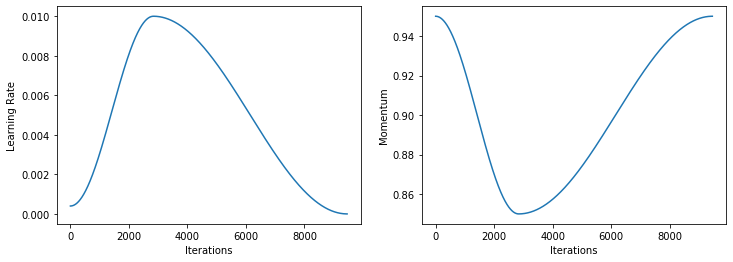

In [16]:
learn.recorder.plot_lr(show_moms=True)
learn.save('food-101-ResNet50-freeze')

### Unfreeze Model

In [17]:
# learn.load('food-101-ResNet50-freeze')

In [18]:
learn.unfreeze()

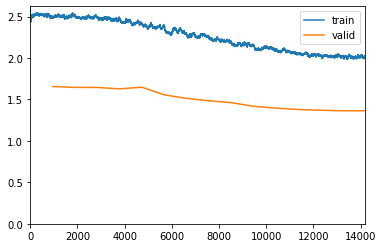

In [19]:
learn.fit_one_cycle(15, max_lr=slice(1e-5, 1e-3))
learn.save('food-101-ResNet50-unfreeze')

## Inference

In [20]:
interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = interp.top_losses()

In [21]:
interp.most_confused(min_val=4)

[('steak', 'filet_mignon', 26),
 ('filet_mignon', 'steak', 23),
 ('chocolate_mousse', 'chocolate_cake', 17),
 ('apple_pie', 'bread_pudding', 15),
 ('chocolate_cake', 'chocolate_mousse', 15),
 ('dumplings', 'gyoza', 13),
 ('prime_rib', 'steak', 13),
 ('beef_tartare', 'tuna_tartare', 12),
 ('bread_pudding', 'apple_pie', 12),
 ('pork_chop', 'steak', 11),
 ('steak', 'pork_chop', 11),
 ('ceviche', 'tuna_tartare', 10),
 ('donuts', 'beignets', 10),
 ('pork_chop', 'filet_mignon', 10),
 ('ramen', 'pho', 10),
 ('tuna_tartare', 'beef_tartare', 10),
 ('baby_back_ribs', 'pork_chop', 9),
 ('gyoza', 'dumplings', 9),
 ('ice_cream', 'frozen_yogurt', 9),
 ('tiramisu', 'chocolate_mousse', 9),
 ('bruschetta', 'caprese_salad', 8),
 ('greek_salad', 'caesar_salad', 8),
 ('lobster_bisque', 'clam_chowder', 8),
 ('scallops', 'gnocchi', 8),
 ('baby_back_ribs', 'steak', 7),
 ('bread_pudding', 'french_toast', 7),
 ('breakfast_burrito', 'huevos_rancheros', 7),
 ('crab_cakes', 'falafel', 7),
 ('croque_madame', 'gril

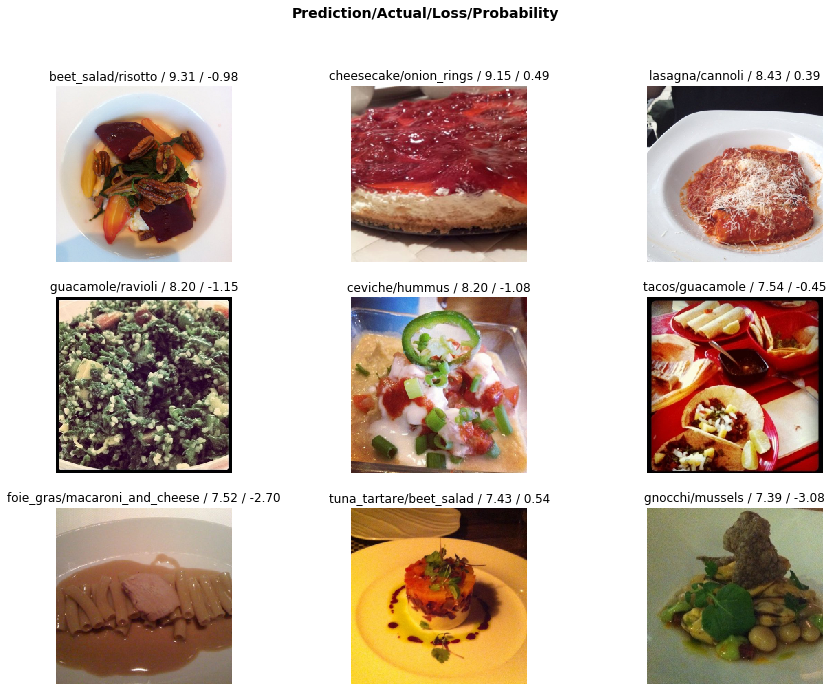

In [22]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

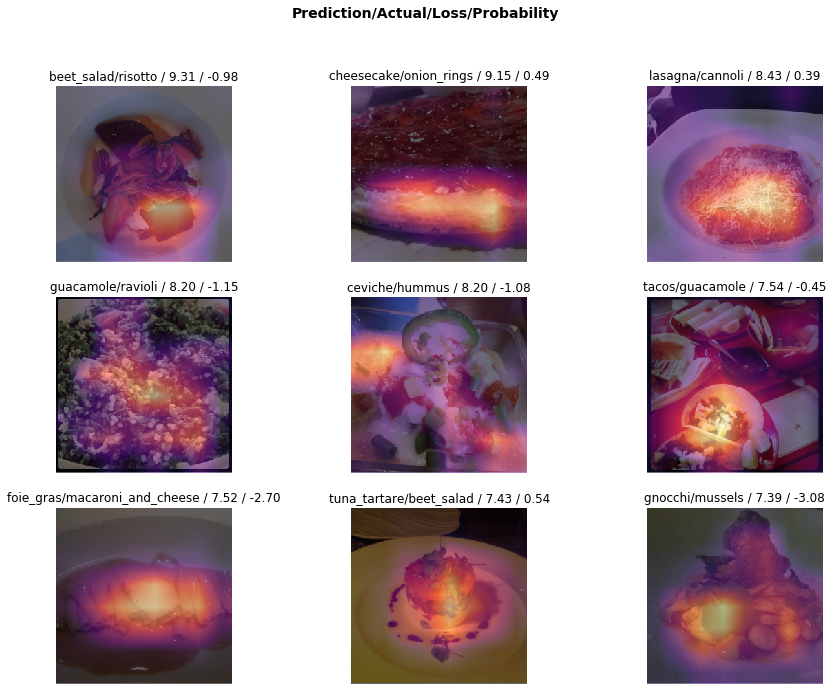

In [23]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

In [24]:
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

In [25]:
test_model_data = (ImageList.from_df(df=test_df,path='.',folder="food-101/images", cols=1)\
                            .split_none()\
                            .label_from_df(cols=0)\
                            .transform(tfms,size=256)\
                            .databunch(bs=64)\
                            .normalize(imagenet_stats))

In [47]:
learn_pred = cnn_learner(test_model_data, models.resnet50, metrics=[accuracy, top_5_accuracy], callback_fns=ShowGraph,
                   loss_func=LabelSmoothingCrossEntropy()).mixup()

In [48]:
learn_pred.load('food-101-ResNet50-unfreeze')

Learner(data=ImageDataBunch;

Train: LabelList (25250 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
apple_pie,apple_pie,apple_pie,apple_pie,apple_pie
Path: .;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, ep

In [51]:
learn_pred.validate(test_model_data.train_dl)

[1.4558167, tensor(0.8042), tensor(0.9503)]

## Test Time Augmentation - TTA

Test-Time Augmentation is an application of data augmentation to the test dataset.
- Have used same augmentaations that were applied on training data
- TTA params: beta = 0.4; scale = 1.35;

In [53]:
y_preds_TTA, y_TTA = learn_pred.TTA(ds_type= test_model_data,beta=0.4, scale=1.35)

top_1_accuracy_TTA = accuracy(y_preds_TTA, y_TTA)
top_5_accuracy_TTA = top_k_accuracy(y_preds_TTA, y_TTA, k=5)

print('TTA: top_1_accuracy: ',top_1_accuracy_TTA )
print('TTA: top_5_accuracy: ',top_5_accuracy_TTA )

TTA: top_1_accuracy:  tensor(0.8815)
TTA: top_5_accuracy:  tensor(0.9780)


In [54]:
interp = ClassificationInterpretation.from_learner(learn_pred, ds_type= test_model_data)

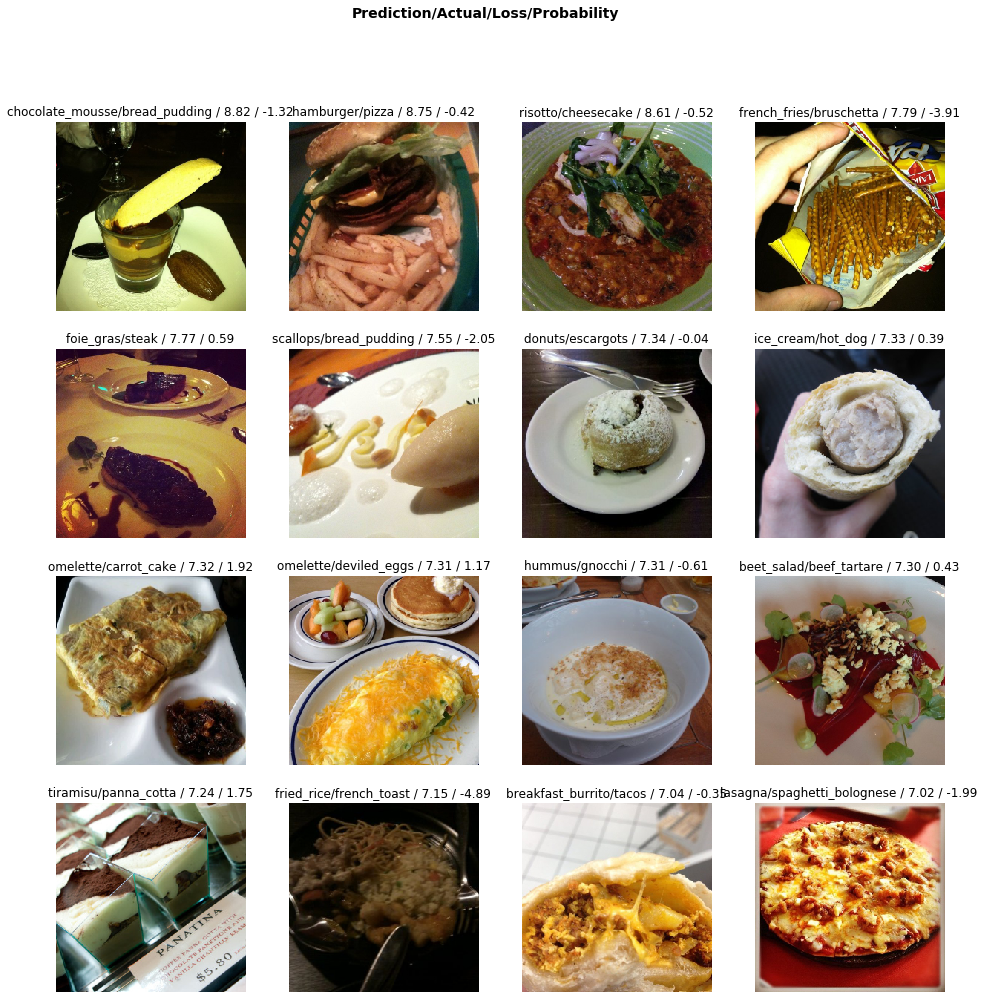

In [55]:
interp.plot_top_losses(16, figsize=(16, 16))

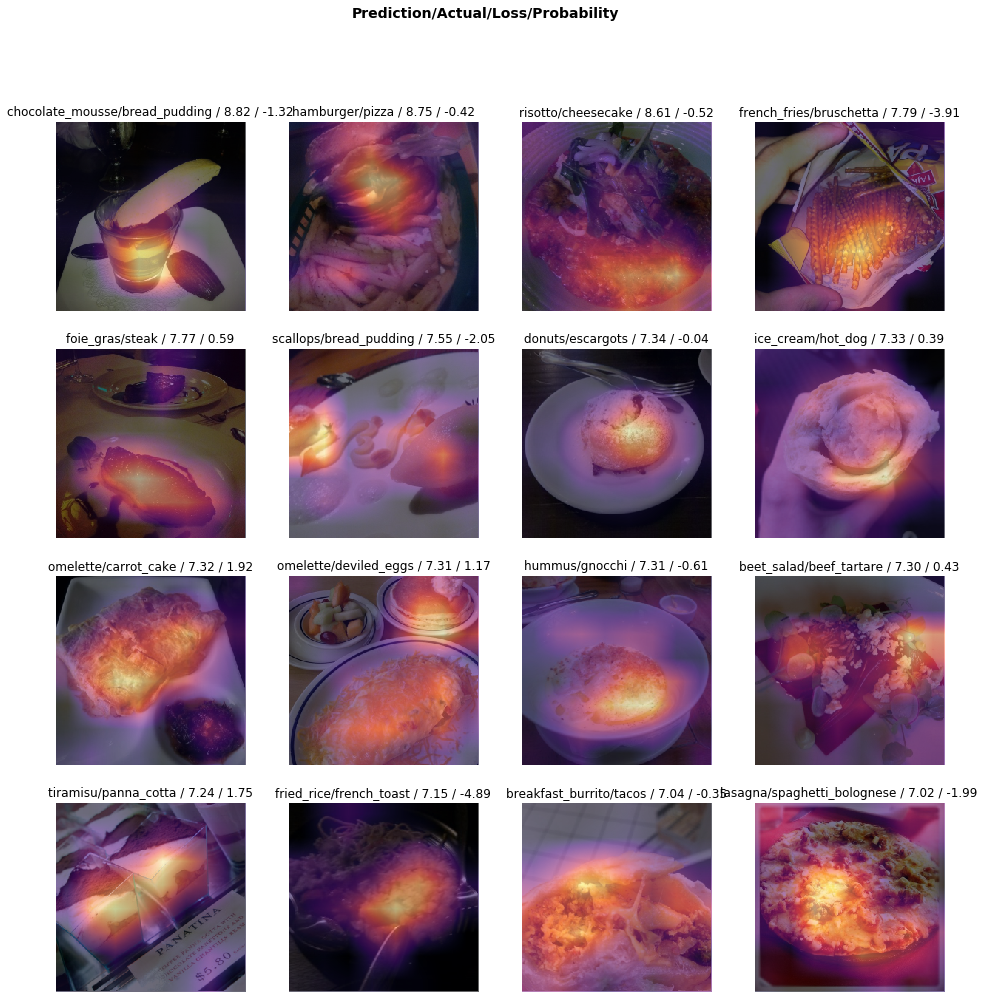

In [56]:
interp.plot_top_losses(16, figsize=(16, 16), heatmap= True)

In [57]:
interp.most_confused(min_val=5)

[('steak', 'filet_mignon', 40),
 ('filet_mignon', 'steak', 27),
 ('pork_chop', 'steak', 22),
 ('chocolate_mousse', 'chocolate_cake', 21),
 ('pork_chop', 'filet_mignon', 21),
 ('tuna_tartare', 'beef_tartare', 21),
 ('prime_rib', 'steak', 19),
 ('ice_cream', 'frozen_yogurt', 16),
 ('apple_pie', 'bread_pudding', 15),
 ('steak', 'pork_chop', 15),
 ('baby_back_ribs', 'steak', 14),
 ('chocolate_cake', 'chocolate_mousse', 14),
 ('pork_chop', 'grilled_salmon', 14),
 ('beef_tartare', 'tuna_tartare', 13),
 ('cheesecake', 'strawberry_shortcake', 13),
 ('nachos', 'tacos', 13),
 ('chicken_quesadilla', 'breakfast_burrito', 12),
 ('dumplings', 'gyoza', 12),
 ('grilled_cheese_sandwich', 'club_sandwich', 12),
 ('pulled_pork_sandwich', 'hamburger', 12),
 ('ravioli', 'gnocchi', 11),
 ('steak', 'prime_rib', 11),
 ('bread_pudding', 'apple_pie', 10),
 ('cheesecake', 'carrot_cake', 10),
 ('donuts', 'beignets', 10),
 ('frozen_yogurt', 'ice_cream', 10),
 ('gnocchi', 'ravioli', 10),
 ('ramen', 'pho', 10),
 ('ri

## Results and Analysis:

- By applying TTA, there has been significant improvement in both top_1_accuracy and top_5_accuracy
- By applying ClassificationInterpretation methods for analysing the results based on top losses, it is easier to tune data augmentation parameters.
- The most_confused method  gives the sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences. This helps in focussing on classes which have more confusion and also explore the cause for the losses.
- We can also observe thatsome of the images have been wrongly labeled.
- Some images have multiple food items and since it is a single label classification problem, some results have been considered wrong. Although,making it a multi-label classification problem will solve this issue

## Future Work:

- Focus on certain classes to improve accuracy. (list of classes can be obtained from the most_confused method)
- Can use deeper networks like ResNet200 or EfficientNet